# 1.Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

# 2.Load Dataset

In [2]:
file_path = r"E:\My Drive\Indonesia AI\Fundamental NLP\Project 1\Data_Processed\tweet_bersih.csv"
df = pd.read_csv(file_path)

# 3.Persiapan Modelling

In [3]:
# 1. Definisikan variabel X dan y
X = df.tweet_bersih.astype(str) # Memastikan semua data adalah string
y = df.sentimen

# 2. Pra-pemrosesan Label (Encoding)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded, num_classes=3)

# 3. Pembagian Data Training dan Testing
# Menggunakan random_state favorit Anda = 16
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.15, random_state=16)

# 4. Tokenisasi dan Padding
max_words = 3000  # Jumlah vocabulary yang digunakan
max_len = 120     # Panjang maksimum sekuens

# Membuat tokenizer
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)

# Mengubah teks menjadi sekuens integer
train_sequences = tok.texts_to_sequences(X_train)
test_sequences = tok.texts_to_sequences(X_test)

# Melakukan padding agar setiap sekuens memiliki panjang yang sama
train_matrix = pad_sequences(train_sequences, maxlen=max_len)
test_matrix = pad_sequences(test_sequences, maxlen=max_len)

# 4.Membuat Pipeline & Training Model

Membangun model LSTM

In [4]:
# 1. Definisi Model Bidirectional LSTM
def build_lstm_model(max_words, max_len):
    """
    Membangun arsitektur model Bidirectional LSTM untuk analisis sentimen.
    """
    # Input Layer
    inputs = Input(name='inputs', shape=[max_len])

    # Embedding Layer
    # Mengubah setiap kata menjadi vektor dengan dimensi 50
    layer = Embedding(max_words, 50, input_length=max_len)(inputs)

    # Bidirectional LSTM Layer
    # Menghasilkan output dengan dimensi 128 (64 * 2)
    layer = Bidirectional(LSTM(64))(layer)

    # Fully Connected Layer (Dense) dengan regularisasi L2
    layer = Dense(32, name='FC1', activation='relu', kernel_regularizer=regularizers.l2(0.0001))(layer)

    # Dropout Layer untuk mencegah overfitting
    layer = Dropout(0.8)(layer)

    # Output Layer dengan 3 kelas (Positif, Negatif, Netral)
    layer = Dense(3, name='out_layer', activation='softmax')(layer)

    # Membuat model
    model = Model(inputs=inputs, outputs=layer)
    return model

# 2. Kompilasi dan Training Model
# Inisialisasi model
model = build_lstm_model(max_words, max_len)
model.summary()

# Kompilasi model dengan optimizer Adam
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Melatih model dengan Early Stopping
# Early stopping akan menghentikan training jika 'val_loss' tidak membaik setelah 3 epoch
history = model.fit(
    train_matrix,
    y_train,
    batch_size=16,
    epochs=10,
    validation_split=0.15,
    callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3)]
)

c:\Users\arjun\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 120, 50)        │       150,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        58,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC1 (Dense)                     │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out_layer (Dense)               │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 213,107 (832.45 KB)

 Trainable params: 213,107 (832.45 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.3725 - loss: 1.1011 - val_accuracy: 0.3750 - val_loss: 1.0940
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.4260 - loss: 1.0722 - val_accuracy: 0.5259 - val_loss: 1.0370
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5557 - loss: 0.9264 - val_accuracy: 0.5733 - val_loss: 0.9369
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6916 - loss: 0.7234 - val_accuracy: 0.6121 - val_loss: 0.9034
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7969 - loss: 0.5336 - val_accuracy: 0.5991 - val_loss: 0.9777
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8435 - loss: 0.4214 - val_accuracy: 0.5905 - val_loss: 1.0604
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8496 - loss: 0.3634 - val_accuracy: 0.6207 - val_loss: 1.4469


# 5.Evaluation

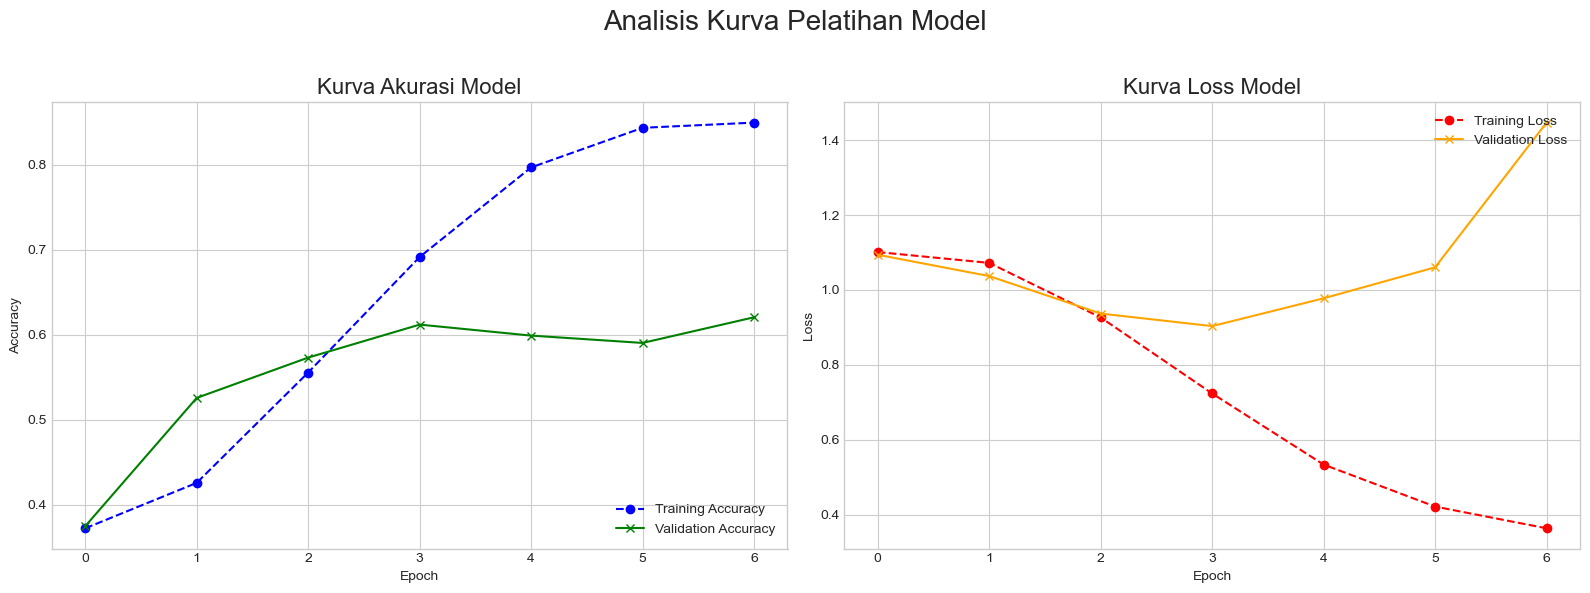

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Akurasi Training          : 0.8496
Akurasi Testing           : 0.6227

Classification Report: 
              precision    recall  f1-score   support

     negatif       0.65      0.62      0.63        92
      netral       0.65      0.59      0.62        93
     positif       0.57      0.66      0.61        88

    accuracy                           0.62       273
   macro avg       0.63      0.62      0.62       273
weighted avg       0.63      0.62      0.62       273



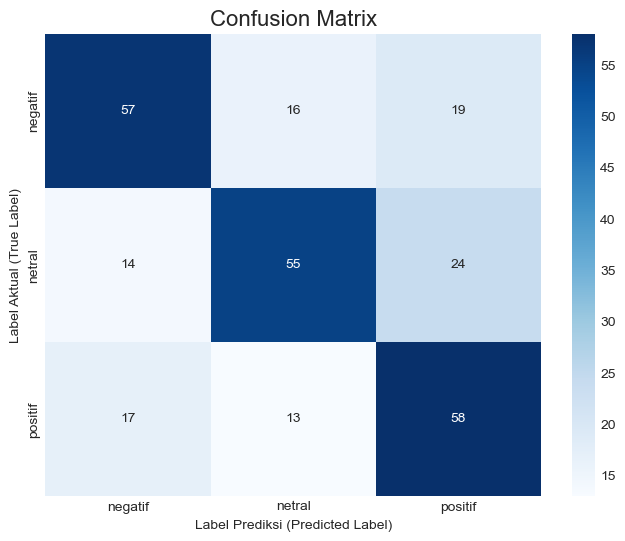

In [15]:
# 1. Mengevaluasi Akurasi Training dan Testing
# Evaluasi pada data test
test_loss, test_acc = model.evaluate(test_matrix, y_test, verbose=0)
# Mendapatkan akurasi training terakhir dari history
train_acc = history.history['accuracy'][-1]

# 2. Plot Kurva Akurasi dan Loss
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot Training & Validation Accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy', color='blue', marker='o', linestyle='--')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green', marker='x')
ax1.set_title('Kurva Akurasi Model', fontsize=16)
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='lower right')

# Plot Training & Validation Loss
ax2.plot(history.history['loss'], label='Training Loss', color='red', marker='o', linestyle='--')
ax2.plot(history.history['val_loss'], label='Validation Loss', color='orange', marker='x')
ax2.set_title('Kurva Loss Model', fontsize=16)
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper right')

plt.suptitle('Analisis Kurva Pelatihan Model', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 3. Membuat Prediksi & Laporan Klasifikasi (Classification Report)

y_pred_probs = model.predict(test_matrix)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Mendapatkan nama kelas dari label encoder
class_names = label_encoder.classes_

print(f"\nAkurasi Training          : {train_acc:.4f}")
print(f"Akurasi Testing           : {test_acc:.4f}")
print("\nClassification Report: ")
print(classification_report(y_true, y_pred, target_names=class_names))


# 4. Membuat dan Memvisualisasikan Matriks Kebingungan (Confusion Matrix)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Label Aktual (True Label)')
plt.xlabel('Label Prediksi (Predicted Label)')
plt.show()
